<a href="https://colab.research.google.com/github/Arjun1999/Architectures/blob/main/StableDiffusion_DeepDive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q --upgrade transformers diffusers ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 94.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 18.5 MB/s eta 0:00:00


In [2]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
# Loading the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Loading the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Init noise sigma :  tensor(14.6146)


0it [00:00, ?it/s]

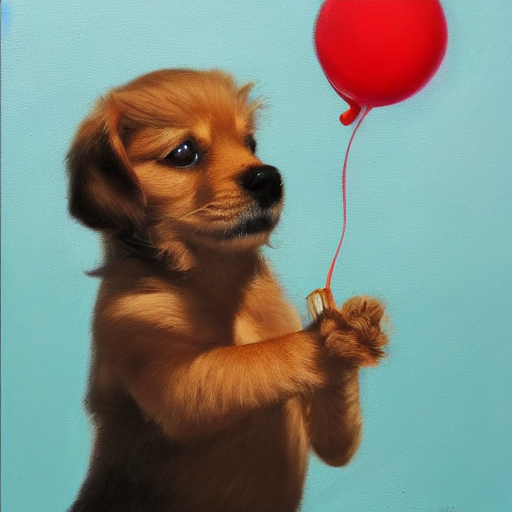

In [16]:
# A copy of the __call__() method of stable diffusion pipeline

prompt = ["An oil painting of a puppy playing with a ballon"]
height = 512
width = 512
num_inference_steps = 30    # Number of denoising steps  
guidance_scale = 7.5        # Weightage to the text input
generator = torch.manual_seed(42)
batch_size = 1

# Preparing text
text_input = tokenizer(prompt, padding='max_length', max_length=tokenizer.model_max_length, truncation = True, return_tensors = "pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]

uncond_input = tokenizer([""] * batch_size, padding='max_length', max_length=max_length, return_tensors = "pt")
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Preparing Scheduler
scheduler.set_timesteps(num_inference_steps)

# Preparing Latents
latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator = generator,)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma       # Scaling the noise

print("Init noise sigma : ", scheduler.init_noise_sigma)

# Inference Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
      # "uncond" + "text"
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]

      # Scaling the latents as per current timestep
      latent_model_input = scheduler.scale_model_input(latent_model_input, t)

      # Predicting noise
      with torch.no_grad():
          noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

      # Guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # "Previous" noisy sample (??)
      latents = scheduler.step(noise_pred, t, latents).prev_sample


# Scaling and decoding the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
  image = vae.decode(latents).sample


# Displaying the image
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]